In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

For this example, we'll suppose that our output variable (damage, or what have you) is well represented by a weibull distribution.  We'll create a large population (in this case, one million years), and then take a sample - in this case, the first 100 years.  

What can we say about the "real" data from only our sample?

In [2]:
np.random.seed(1234)
population = np.random.weibull(1,1000000)
sample = population[0:100]

We can do a quick plot of the data with a CDF, comparing the sample to the population.

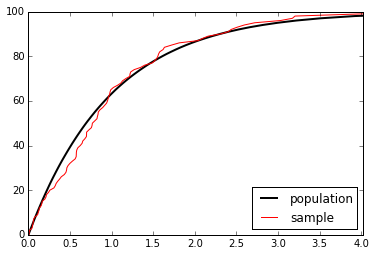

In [3]:
# Define percentiles, 0 to 100
prc = np.linspace(0,100,101)

# Calculate values for those p
sample_cdf = np.percentile(sample,prc)
population_cdf = np.percentile(population,prc)
plt.plot(population_cdf,prc,'k',linewidth=2)
plt.plot(sample_cdf,prc,'r')
plt.xlim((0,np.percentile(sample,99)))
_ = plt.legend(['population','sample'],loc='lower right')

Our sample differs somewhat from the population, but some variation is normal.  We can visualize the regularity by constructing some confidence intervals.  In this case, we'll use the bootstrapping technique (http://bit.ly/1hKKIfM) to do it.

In [4]:
def bootstrap_cdf(sample,prange,k=10000,strap_width=len(sample)):

    # Prepare the output data structure
    results = np.zeros((k,len(prange)))
    
    # Sample randomly, and record results
    for i in range(k):
        s = np.random.choice(sample,size=strap_width,replace=True)
        results[i,:] = np.percentile(s,prange)
    
    # Calculate estimates    
    bounds_5 = np.percentile(results,5,axis=0)
    bounds_95 = np.percentile(results,95,axis=0)
    
    return bounds_5,bounds_95

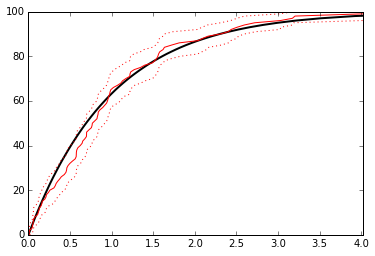

In [5]:
# Run the bootstrap, 10,000 times
sample_cdf_5,sample_cdf_95 = bootstrap_cdf(sample,prc,k=10000)

# Plot the results
plt.plot(population_cdf,prc,'k',linewidth=2)
plt.plot(sample_cdf,prc,'r')
plt.plot(sample_cdf_5,prc,'r:')
plt.plot(sample_cdf_95,prc,'r:')
_ = plt.xlim((0,np.percentile(sample,99)))

We can evaluate how often our "true" data was within the 90% confidence interval.  If our technique works well, it should be within the bounds about 90 percent of the time (95 - 5).  Values here will vary randomly, but they should center on 90.  If they undershoot this, the confidence intervals are too narrow and you miss your guess too often.  If this value is too high, the confidence intervals are too wide and lack precision.

In [6]:
(100.0 * np.sum((population_cdf >= sample_cdf_5) & (population_cdf <= sample_cdf_95))) / len(prc)

94.05940594059406

Any extrapolation from our sample (e.g., via a Monte Carlo selection) will produce essentially the same results, though often with slightly worse (too conservative) CI estimates.

95.04950495049505

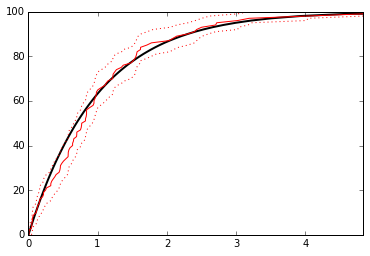

In [7]:
# Create a projection for the next 5,000 years based on our 100-year sample.
projection = np.random.choice(sample,size=5000,replace=True)

# Calculate CDF
projection_cdf = np.percentile(projection,prc)
projection_cdf_5, projection_cdf_95 = bootstrap_cdf(projection,prc,k=10000)

# Plot results
plt.plot(population_cdf,prc,'k',linewidth=2)
plt.plot(projection_cdf,prc,'r')
plt.plot(projection_cdf_5,prc,'r:')
plt.plot(projection_cdf_95,prc,'r:')
_ = plt.xlim((0,np.percentile(projection,99)))

(100.0 * np.sum((population_cdf >= projection_cdf_5) & (population_cdf <= projection_cdf_95))) / len(prc)


How does this compare to previous work on the tornado data?

In [8]:
df = pd.read_csv('data/10k.csv')
grp = df.groupby('year')
impact = grp['impact'].agg('sum')

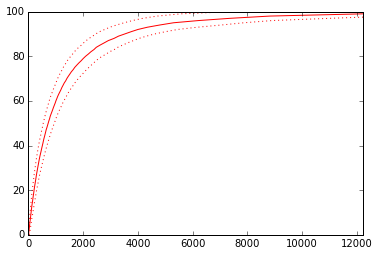

In [9]:
impact_cdf = np.percentile(impact,prc)
impact_cdf_5, impact_cdf_95 = bootstrap_cdf(impact,prc,k=10000)

# Plot results
plt.plot(impact_cdf,prc,'r')
plt.plot(impact_cdf_5,prc,'r:')
plt.plot(impact_cdf_95,prc,'r:')
_ = plt.xlim((0,np.percentile(impact,99)))